In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add parent directory to path for imports
sys.path.append('..')

In [2]:
# Import project modules
from dataset_preprocessing.dataset import BUSIDataset, create_data_loaders
from models.unet import UNet
from models.loss import dice_loss, combined_loss
from models.metrics import calculate_metrics, visualize_results

In [3]:
# 1. Check U-Net Model Architecture

# Initialize the U-Net model
model = UNet(in_channels=1, out_channels=1)

# Display model architecture summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"U-Net with Residual Connections has {count_parameters(model):,} trainable parameters.")

# Test with a random input tensor
x = torch.randn(2, 1, 256, 256)  # Batch size 2, 1 channel, 256x256 image
output = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

U-Net with Residual Connections has 8,045,953 trainable parameters.
Input shape: torch.Size([2, 1, 256, 256])
Output shape: torch.Size([2, 1, 256, 256])


Found 50 image-mask pairs in ../Dataset_BUSI_with_GT/benign
Using bilateral denoising method


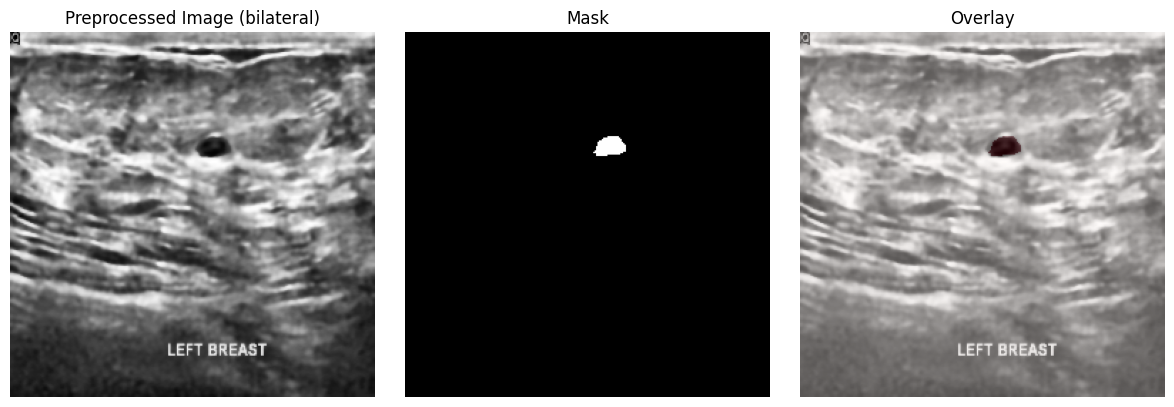

Image shape: (256, 256)
Mask shape: (256, 256)
Image range: [0.023, 1.000]
Mask unique values: [0. 1.]


In [4]:
# 2. Load and Visualize Dataset

# Load dataset with bilateral filtering
data_dir = "../Dataset_BUSI_with_GT/benign"

# Create a dataset instance with bilateral filtering
dataset = BUSIDataset(
    data_dir=data_dir,
    denoising_method="bilateral",
    limit_samples=50  # Limit for testing, remove for full dataset
)

# Visualize one sample
idx = 0  # First sample
dataset.visualize_sample(idx)

In [5]:
# 3. Create Data Loaders

# Create training and validation data loaders
train_loader, val_loader = create_data_loaders(
    data_dir=data_dir,
    batch_size=8,
    train_val_split=0.8,
    denoising_method="bilateral",
    num_workers=4,
    limit_samples=50  # Limit for testing, remove for full dataset
)

Found 50 image-mask pairs in ../Dataset_BUSI_with_GT/benign
Using bilateral denoising method
Created data loaders with 5 training batches and 2 validation batches


Batch images shape: torch.Size([8, 1, 256, 256])
Batch masks shape: torch.Size([8, 1, 256, 256])
Model output shape: torch.Size([8, 1, 256, 256])


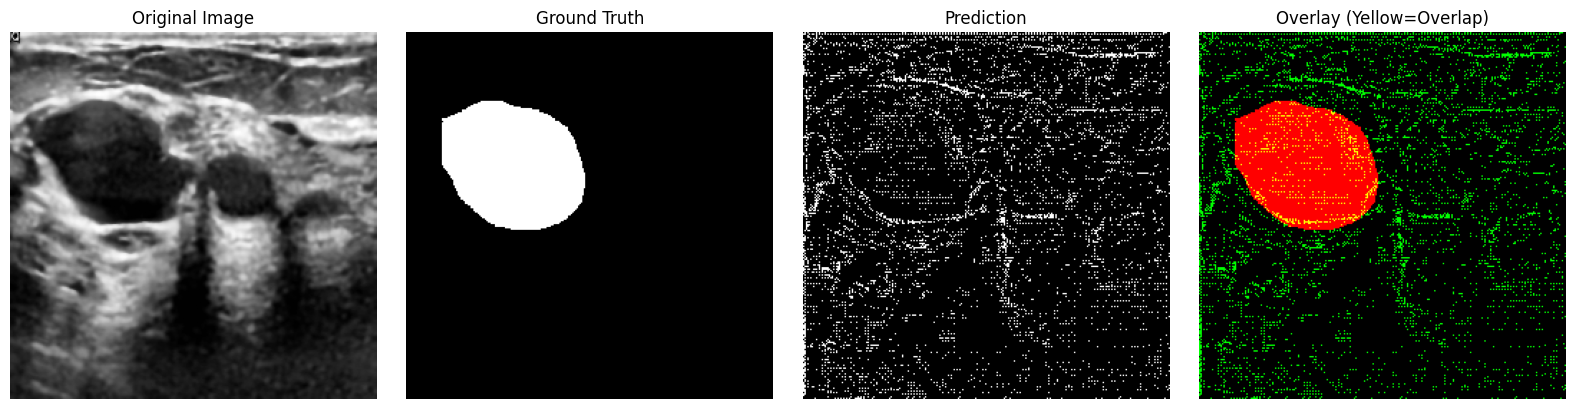

In [6]:
# 4. Test Forward Pass with Real Data

# Get a batch from the data loader
for batch in train_loader:
    images = batch['image']
    masks = batch['mask']
    break

# Forward pass through model
with torch.no_grad():
    outputs = model(images)

print(f"Batch images shape: {images.shape}")
print(f"Batch masks shape: {masks.shape}")
print(f"Model output shape: {outputs.shape}")

# Apply sigmoid to get probabilities
probs = torch.sigmoid(outputs)

# Visualize the results for the first image in batch
visualize_results(
    image=images[0],
    true_mask=masks[0],
    pred_mask=probs[0]
)

In [7]:
# 5. Test Loss Functions

# Test Dice loss
dice = dice_loss(outputs, masks)
print(f"Dice Loss: {dice.item():.4f}")

# Test combined loss
combined = combined_loss(outputs, masks, alpha=0.5)
print(f"Combined Loss (alpha=0.5): {combined.item():.4f}")

Dice Loss: 0.8734
Combined Loss (alpha=0.5): 0.7208


In [8]:
# 6. Test Evaluation Metrics

# Calculate metrics for the batch
metrics = calculate_metrics(probs, masks)

for metric_name, value in metrics.items():
    print(f"{metric_name.capitalize()}: {value:.4f}")

Dice: 0.0803
Iou: 0.0418
Precision: 0.0704
Recall: 0.0936
